# Data exploration for joining all data sources

In this notebook we develop the functions for retrieving the tables, preparing them for the join, and then combining them based on the timestamp. 

## Imports

In [13]:
import os
import pandas as pd
import numpy as np
import csv
import time
import datetime
import collections
from abc import abstractmethod
import matplotlib.pyplot as plt

## Sources
In the following section we construct the methods to read the different csv files and convert them to flat tables. 

In [14]:
class Locations(): 
    
    _location = "../data/sample/"
    ssd = _location + "-20220314-100806-Slot1-In2.csv"
    pmt = _location + "all_data.csv"
    coil = _location + "coil_log.txt"
    heater = _location + "HeaterLog_20220314_100740_00001.csv"
    ion = _location + "IonBeamControl1.5_DESKTOP-8ICG2TJ_20220314_114132.csv"
    gauge = _location + "TPG256GaugeMonitor_Single_DESKTOP-BEF5FI4_20220312_203214.csv"
    laser = _location + "15.03.2022, 21.30, 384.22817013 THz.lta"
    image = _location + "cmos_000039.csv"
    
loc = Locations()

In [15]:
class Recorder(object): 
    """ Base class for mapping a csv file to a pandas dataframe in real-time when it changes. 
    """
    
    def __init__(self, filepath: str, has_metadata: bool=True): 
        # Settings
        self.filepath = filepath
        self.has_metadata = has_metadata
        
        # Tracking
        self.read_data_lines = 0
        self.last_updated = 0
        self.data_last_updated = 0
        self.metadata_last_updated = 0
        
        # Dataframes 
        self._table_df = None     # Data x Metadata
        self._data_df = None      # Data
        self._metadata_df = None  # Metadata

    def get_table(self) -> pd.DataFrame: 
        self._update()
        self.last_updated = self._get_mod_time()
        return self._table_df
    
    def get_data(self) -> pd.DataFrame: 
        self._update_data()
        self.data_last_updated = self._get_mod_time()
        return self._data_df
    
    def get_metadata(self) -> pd.DataFrame:
        if not self.has_metadata: 
            return pd.DataFrame()
        self._update_metadata()
        self.metadata_last_updated = self._get_mod_time()
        self.metadata_columns = list(self._metadata_df.columns) if self._metadata_df is not None else []
        return self._metadata_df
    
    def table_is_up_to_date(self) -> bool:
        return self.last_updated == self._get_mod_time()
    
    def data_is_up_to_date(self) -> bool: 
        return self.data_last_updated == self._get_mod_time()
    
    def metadata_is_up_to_date(self) -> bool: 
        return self.metadata_last_updated == self._get_mod_time()
    
    def _update(self): 
        if self.table_is_up_to_date(): 
            return 
        
        # Merge with metadata
        self._data_df = self.get_data()
        if self.has_metadata: 
            self._metadata_df = self.get_metadata()
            self._table_df = self._data_df.merge(self._metadata_df, how='cross')
        else: 
            self._table_df = self._data_df
            
        # Order 
        self._harmonize_time()
        self._table_df = self._table_df.sort_values(by="timestamp")
        self.last_updated = self._get_mod_time()
        
    def _get_mod_time(self): 
        return time.ctime(os.path.getmtime(self.filepath))
        
    def _update_data(self):
        """ Updates self._data_df and self.data_last_updated incrementally. Makes use of _load_new_data(). 
        """
        
        # Case first loading 
        if self.read_data_lines == 0: 
            self._data_df = self._load_new_data()
            return 
        
        # Case reloading
        new_data_df = self._load_new_data()
        if len(new_data_df.index) == 0: 
            return

        # Concatenate old and new
        self._data_df = pd.concat(
            [self._data_df, new_data_df],
            axis=0,
            join="outer",
            ignore_index=True,
            copy=True
        )
        return
    
    def _update_metadata(self): 
        self._metadata_df = self._load_metadata() if not self.metadata_is_up_to_date() else self._metadata_df
        return
    
    def _timestamp_to_datetimes(self, df: pd.DataFrame): 
        """ Takes a pandas dataframe with a timestamp column (int) and also adds date datetime, datetime_ms, datetime_μs. 
        """
        # Conversion functions
        conversion_to_datetime_μs = lambda x: datetime.datetime.fromtimestamp(x/1000000000).strftime('%Y-%m-%d %H:%M:%S.%f')
        conversion_to_datetime_ms = lambda x: datetime.datetime.fromtimestamp(x/1000000000).strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]
        conversion_to_datetime = lambda x: datetime.datetime.fromtimestamp(x/1000000000).strftime('%Y-%m-%d %H:%M:%S')

        # Apply conversions
        df["datetime_μs"] = df["timestamp"].apply(conversion_to_datetime_μs)
        df["datetime_ms"] = df["timestamp"].apply(conversion_to_datetime_ms)
        df["datetime"] = df["timestamp"].apply(conversion_to_datetime)

        return
    
    @abstractmethod
    def _load_new_data(self) -> pd.DataFrame: 
        """ Returns the rows which have not been loaded so far. 
        """
    
        pass
    
    @abstractmethod
    def _load_metadata(self) -> pd.DataFrame: 
        """ Returns the current version of the metadata by reloading everything. 
        """
        pass
    
    @abstractmethod
    def _harmonize_time(self): 
        pass

### SSD2 Data
Data from the WE7000 DAQ for the SSD2. The PMT current from the MOT will be obtained like this in our next experiment.

In [16]:
class SSDRecorder(Recorder): 
    """ Class for data engineering of the SSD2 data. """

    def __init__(self, filepath: str=loc.ssd):
        super(SSDRecorder, self).__init__(filepath, True)
        self.nr_meta_data_rows = 37

    def _load_new_data(self) -> pd.DataFrame: 
        """ Just load the new part. """
        df = pd.read_csv(filepath_or_buffer=self.filepath, 
                         skiprows=self.nr_meta_data_rows + self.read_data_lines, 
                         header=0, 
                         names=["TraceName", "Time_x", "PulseHeight"])        
        self.read_data_lines += len(df.index)
        return df
        
    def _load_metadata(self): 
        """ Overwrite the metadata with the new version. """
        with open(self.filepath, newline='') as f:
            reader = csv.reader(f)
            metadata = list(reader)[:(self.nr_meta_data_rows + 1)]
            metadata =  metadata[:3] +  metadata[4:]
            columns = [line[0] for line in metadata]
            row = [line[1] for line in metadata]
            return pd.DataFrame(data=[row], columns=columns)
                
    def _harmonize_time(self): 
        """ Convert the relative time and start time to the real time. """
        
        def harmonize_table(df: pd.DataFrame) -> pd.DataFrame: 
            # Start time
            helper_df = pd.DataFrame()
            helper_df["start_datetime_str"] = df["//StartDate"].apply(lambda s: s.replace("/", "-")) + " " + df["//StartTime"]
            helper_df["start_datetime"] = pd.to_datetime(helper_df["start_datetime_str"]) 

            # Conversion parameter: Time_x * rel_time_to_ns = rel. time in ns
            time_resolution = df['//TimeResolution'][0]
            rel_time_to_ns = {
                '1.000000e-009': 1e-0,
                '1.000000e-006': 1e+3,
                '1.000000e-003': 1e+6
            }[time_resolution]

            # Real time
            helper_df["relative_time_ns"] = df["Time_x"] * rel_time_to_ns
            helper_df["start_ns"] = helper_df.start_datetime.values.astype(np.int64)
            helper_df["timestamp"] = helper_df["start_ns"] + helper_df["relative_time_ns"]

            # Add datetimes
            df["timestamp"] = helper_df["timestamp"]
            self._timestamp_to_datetimes(df)
            return df
        
        self._table_df = harmonize_table(self._table_df)
        self._data_df = self._table_df[self._data_df.columns]

In [17]:
ssd_recorder = SSDRecorder()
ssd_recorder.get_table().head(1)

,TraceName,Time_x,PulseHeight,Model,BlockNumber,BlockSize,VUnit,HResolution,HUnit,Date,...,//StopSource,//TimeResolution,//TimeStamp,//RealTime,//LiveTime,//DeadTime(%),timestamp,datetime_μs,datetime_ms,datetime
0,0,553786,2463,WE7562,1,15262,cnt,1.000000e+000,?,2022/03/14,...,None,1.000000e-006,Peak,7.136569e+003,7.136410e+003,2.233544e-003,1.647252e+18,2022-03-14 19:07:54.553786,2022-03-14 19:07:54.553,2022-03-14 19:07:54


In [18]:
ssd_recorder.get_data().head(1)

,TraceName,Time_x,PulseHeight
0,0,553786,2463


In [19]:
ssd_recorder.get_metadata().head(1)

,Model,BlockNumber,BlockSize,VUnit,HResolution,HUnit,Date,Time,//Comment,//StartDate,...,//GateFunction,//TriggerOutput,//SignalType,//Synchronize,//StopSource,//TimeResolution,//TimeStamp,//RealTime,//LiveTime,//DeadTime(%)
0,WE7562,1,15262,cnt,1.000000e+000,?,2022/03/14,10:07:54,,2022/03/14,...,None,None,Trigger,OFF,None,1.000000e-006,Peak,7.136569e+003,7.136410e+003,2.233544e-003


### SSD Histogram representation
A very useful representation of the SSD data is when we group by time (primary key) and then count the number of pulses with a certain hight. The columns then correspond to voltage ranges in 12-bit (0, 1, 2, 3, ..., 4094, 4095) encoding. 

In [20]:
class SSDRepresentation(): 
    
    def __init__(self, ssd_recorder: SSDRecorder): 
        self.ssd_recorder = ssd_recorder
    
    def get_hist_rep(self) -> pd.DataFrame: 
        ssd_df = self.ssd_recorder.get_table()
        nr_of_channels = ssd_df["//Gain"][0]
        
        # Groupby timestamp and PulseHeight (channel)
        grouped = ssd_df.groupby(by=["datetime", "PulseHeight"])
        df = grouped.agg({"TraceName": 'count'}).rename({"TraceName": "PulseCount"}, axis=1)
        df = df.unstack(level='PulseHeight').fillna(0, downcast="infer")
        
        # Fix column names
        df.columns = df.columns.to_flat_index()
        df.columns = [str(col[1]) for col in df.columns.values]
            
        return df
    
    def get_time_aggregated_hist_rep(self) -> pd.DataFrame: 
        df = self.get_hist_rep() 
        df_sum = df.sum()
        df = pd.DataFrame(data=[df_sum.values], columns=df_sum.index.values)
        return df
    
    def get_channel_aggregated_hist_rep(self) -> pd.DataFrame: 
        """ TODO: Implement aggregation over all channels. 
        """
        
        df = self.get_hist_rep()
        df_channel = df.sum(axis=1, min_count=1).to_frame()
        return df_channel

In [21]:
ssd_representation = SSDRepresentation(ssd_recorder)
ssd_representation.get_hist_rep().head(1)

,500,501,502,503,504,505,506,507,508,509,...,3543,3556,3661,3676,3719,3842,3929,3977,3984,4000
datetime,,,,,,,,,,,,,,,,,,,,,
2022-03-14 19:07:54,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
ssd_representation.get_time_aggregated_hist_rep().head(1)

,500,501,502,503,504,505,506,507,508,509,...,3543,3556,3661,3676,3719,3842,3929,3977,3984,4000
0,2,4,6,1,3,2,3,3,2,6,...,1,1,1,1,1,1,1,1,1,1


In [23]:
ssd_representation.get_channel_aggregated_hist_rep().head(1)

,0
datetime,
2022-03-14 19:07:54,2


### PMT Data
In the table, we have the following columns. 
- No. : Frame number of CMOS camera
- Time: When the frame is obtained
- PMT Current: Current from photomultiplier at the time the frame obtained
- ROI Sum: The sum of signal values in ROI
- Coil (1:ON 0:ODD): The current of the coil at that time

Comment: 
- Will be depraced and replaced by the SSD. 

In [24]:
class PMTRecorder(Recorder): 
    
    def __init__(self, filepath: str=loc.pmt):
        super(PMTRecorder, self).__init__(filepath, False)
    
    def _load_new_data(self): 
        
        # First time 
        if self.read_data_lines == 0: 
            df = pd.read_csv(filepath_or_buffer=self.filepath, skiprows=self.read_data_lines)
            df = df.drop(["Unnamed: 5"], axis=1)

        # Later time 
        else: 
            df = pd.read_csv(
                filepath_or_buffer=self.filepath, 
                skiprows=self.read_data_lines, 
                names=self._data_df.columns
            )
        self.read_data_lines += len(df.index)
        return df
    
    def _harmonize_time(self):
        
        # Harmonize table
        self._table_df["datetime_μs"] = self._table_df["Time"].apply(lambda s: s+"000")
        self._table_df["datetime_ms"] = self._table_df["Time"]
        self._table_df["datetime"] = self._table_df["Time"].apply(lambda s: s[:-4])
        self._table_df["timestamp"] = self._table_df["Time"].apply(pd.Timestamp).values.astype(np.int64)
        
        # Create sub tables
        self._data_df = self._table_df
        self._metadata_df = pd.DataFrame()

        return 

In [25]:
pmt_recorder = PMTRecorder()
pmt_recorder.get_table().head(1)

,No.,Time,PMT Current (A),ROI Sum,Coil (1:ON 0:OFF),datetime_μs,datetime_ms,datetime,timestamp
0,1,2022/03/15 08:18:00.266,-1.519308e-13,1491678,1,2022/03/15 08:18:00.266000,2022/03/15 08:18:00.266,2022/03/15 08:18:00,1647332280266000000


In [26]:
pmt_recorder.get_data().head(1)

,No.,Time,PMT Current (A),ROI Sum,Coil (1:ON 0:OFF),datetime_μs,datetime_ms,datetime,timestamp
0,1,2022/03/15 08:18:00.266,-1.519308e-13,1491678,1,2022/03/15 08:18:00.266000,2022/03/15 08:18:00.266,2022/03/15 08:18:00,1.647332e+18


In [27]:
pmt_recorder.get_metadata().head(1)

""


### Coil Log
The current of the MOT coil is controlled by a relay switch. This text file is the log of the relay switch.

In [28]:
class CoilRecorder(Recorder): 
       
    def __init__(self, filepath: str=loc.coil):
        super(CoilRecorder, self).__init__(filepath, False)
    
    def _load_new_data(self): 
        df = pd.read_csv(filepath_or_buffer=self.filepath, delimiter="	", skiprows=self.read_data_lines)
        self.read_data_lines += len(df.index)
        return df
    
    def _harmonize_time(self): 
        self._table_df["datetime_μs"] = self._table_df["Time"].apply(lambda s: s+"000")
        self._table_df["datetime_ms"] = self._table_df["Time"]
        self._table_df["datetime"] = self._table_df["Time"].apply(lambda s: s[:-4])
        self._table_df["timestamp"] = self._table_df["Time"].apply(pd.Timestamp).values.astype(np.int64)
        
        # Create sub tables
        self._data_df = self._table_df
        self._metadata_df = pd.DataFrame()
        return 

In [29]:
coil_recorder = CoilRecorder() 
coil_recorder.get_table().head(1)

,Time,CoilOperation,datetime_μs,datetime_ms,datetime,timestamp
0,2022/03/14 12:09:23,ON,2022/03/14 12:09:23000,2022/03/14 12:09:23,2022/03/14 12:0,1647259763000000000


In [30]:
coil_recorder.get_data().head(1)

,Time,CoilOperation,datetime_μs,datetime_ms,datetime,timestamp
0,2022/03/14 12:09:23,ON,2022/03/14 12:09:23000,2022/03/14 12:09:23,2022/03/14 12:0,1647259763000000000


In [31]:
coil_recorder.get_metadata().head(1)

""


### Heater Log
Log of the IR heater output percentage for target heating. 

In [32]:
class HeaterRecorder(Recorder): 
    """ Class for data engineering of the heater data. """
    
    def __init__(self, filepath: str=loc.heater):
        super(HeaterRecorder, self).__init__(filepath, False)
        self.nr_meta_data_rows = 6
    
    def _load_new_data(self) -> pd.DataFrame:  
        df = pd.read_csv(filepath_or_buffer=self.filepath, 
                                 skiprows=self.nr_meta_data_rows+self.read_data_lines, 
                                 header=0, 
                                 names=["Date", "Time", "Unknown", "TargetPercentage", "MeasuredPercentage"],
                                 encoding="cp932")
        self.read_data_lines += len(df.index)
        return df
    
    def _load_metadata(self): 
        with open(self.filepath, newline='', encoding="cp932") as f:
            reader = csv.reader(f)
            metadata_list = list(reader)[:self.nr_meta_data_rows]
            columns = [m[0] for m in metadata_list]
            row = [metadata_list[i][1] for i in range(2)] +  [f"{metadata_list[i][3]},{metadata_list[i][4]}" for i in range(2, 6)]
            return pd.DataFrame(data=[row], columns=columns)
    
    def _harmonize_time(self): 
        self._table_df["datetime"] = self._table_df["Date"].apply(lambda s: s.replace("/", "-")) + " " + self._table_df["Time"]
        self._table_df["datetime_μs"] = self._table_df["datetime"].apply(lambda s: s+".000000")
        self._table_df["datetime_ms"] = self._table_df["datetime"].apply(lambda s: s+".000")
        self._table_df["timestamp"] = self._table_df["datetime_ms"].apply(pd.Timestamp).values.astype(np.int64)
        
        # Create sub tables
        self._data_df = self._table_df[list(self._data_df.columns) + ["datetime", "datetime_μs", "datetime_ms", "timestamp"]]
        self._metadata_df = self._table_df[list(self._metadata_df.columns)]
        
        return

In [33]:
heater_recorder = HeaterRecorder()
heater_df = heater_recorder.get_table().head(1)

AttributeError: 'NoneType' object has no attribute 'columns'

In [ ]:
heater_recorder.get_data().head(1)

In [ ]:
heater_recorder.get_metadata().head(1)

### Ion Beam Control
Log of the Fr ion source. First day of experiment, right after the end of primary beam check, just starting the Fr ion extraction. The column "FC" is the current from either one of the faraday cups, or the sum of both.
The columns "Center" and "Surrounding" are the voltages applied to the mechanical relay switches that connects the faraday cups to the picoammeter. For example, if "Center" = 24 and "Surrounding" = 0, the value at "FC" is the current observed on FC Center in nA.

In [37]:
class IonRecorder(Recorder): 
    
    def __init__(self, filepath: str=loc.ion):
        super(IonRecorder, self).__init__(filepath, False)

    def _load_new_data(self): 
        df = pd.read_csv(filepath_or_buffer=self.filepath, skiprows=self.read_data_lines)
        self.read_data_lines += len(df.index)
        return df
    
    def _harmonize_time(self): 
        self._table_df["datetime"] = pd.to_datetime(self._table_df["Timestamp"])
        self._table_df["datetime_μs"] = self._table_df["Timestamp"].apply(lambda s: s+".000000")
        self._table_df["datetime_ms"] = self._table_df["Timestamp"].apply(lambda s: s+".000")
        self._table_df["timestamp"] = self._table_df["datetime"].values.astype(np.int64)
        return

In [38]:
ion_recorder = IonRecorder()
ion_recorder.get_table().head(1)

,Timestamp,Be Bypass,Fr Beamline,Center,Surrounding,FC,NC,Be temp (degC),He press (V),Au temp (V),...,Einzel Current,Drift 2 Current,Freq (kHz),Phase (deg),Amp(CH1) (Vpp),Amp(CH2) (Vpp),datetime,datetime_μs,datetime_ms,timestamp
0,2022/03/14 11:41:38,0.00201,0.000044,0.0,0.0,-0.000301,0.0,0.00005,3.0185,0.71115,...,-2.800000e-07,4.000000e-08,0,0,0,0,2022-03-14 11:41:38,2022/03/14 11:41:38.000000,2022/03/14 11:41:38.000,1647258098000000000


In [39]:
ion_recorder.get_data().head(1)

,Timestamp,Be Bypass,Fr Beamline,Center,Surrounding,FC,NC,Be temp (degC),He press (V),Au temp (V),...,Einzel Current,Drift 2 Current,Freq (kHz),Phase (deg),Amp(CH1) (Vpp),Amp(CH2) (Vpp),datetime,datetime_μs,datetime_ms,timestamp
0,2022/03/14 11:41:38,0.00201,0.000044,0.0,0.0,-0.000301,0.0,0.00005,3.0185,0.71115,...,-2.800000e-07,4.000000e-08,0,0,0,0,2022-03-14 11:41:38,2022/03/14 11:41:38.000000,2022/03/14 11:41:38.000,1647258098000000000


In [40]:
ion_recorder.get_metadata().head(1)

""


### Gauge Monitor

In [41]:
class GaugeRecorder(Recorder): 
    
    def __init__(self, filepath: str=loc.gauge):
        super(GaugeRecorder, self).__init__(filepath, False)
    
    def _load_new_data(self): 
        df = pd.read_csv(filepath_or_buffer=self.filepath, skiprows=self.read_data_lines)
        self.read_data_lines += len(df.index)
        return df
    
    def _harmonize_time(self): 
        self._table_df["datetime"] = pd.to_datetime(self._table_df["Timestamp"])
        self._table_df["datetime_μs"] = self._table_df["Timestamp"].apply(lambda s: s+".000000")
        self._table_df["datetime_ms"] = self._table_df["Timestamp"].apply(lambda s: s+".000")
        self._table_df["timestamp"] = self._table_df["datetime"].values.astype(np.int64)
        return 

In [42]:
gauge_recorder = GaugeRecorder()
gauge_recorder.get_table()

,Timestamp,Rb disp.,Neut.,Surf. Ref.,NC,NC.1,NC.2,datetime,datetime_μs,datetime_ms,timestamp
0,2022/03/12 20:32:19,8.950000e-07,1.342000e-06,8.270000e-07,1.000000e-09,5.009000e-02,0.05009,2022-03-12 20:32:19,2022/03/12 20:32:19.000000,2022/03/12 20:32:19.000,1647117139000000000
1,2022/03/12 20:32:20,8.930000e-07,1.334000e-06,8.260000e-07,1.000000e-09,5.009000e-02,0.05009,2022-03-12 20:32:20,2022/03/12 20:32:20.000000,2022/03/12 20:32:20.000,1647117140000000000
2,2022/03/12 20:32:21,8.910000e-07,1.336000e-06,8.280000e-07,1.000000e-09,5.009000e-02,0.05009,2022-03-12 20:32:21,2022/03/12 20:32:21.000000,2022/03/12 20:32:21.000,1647117141000000000
3,2022/03/12 20:32:22,8.950000e-07,1.337000e-06,8.280000e-07,2.000000e-07,5.009000e-02,0.05009,2022-03-12 20:32:22,2022/03/12 20:32:22.000000,2022/03/12 20:32:22.000,1647117142000000000
4,2022/03/12 20:32:23,8.940000e-07,1.336000e-06,8.270000e-07,2.000000e-07,5.009000e-02,0.05009,2022-03-12 20:32:23,2022/03/12 20:32:23.000000,2022/03/12 20:32:23.000,1647117143000000000
...,...,...,...,...,...,...,...,...,...,...,...
264358,2022/03/15 21:59:39,5.010000e-07,5.000000e-07,5.000000e-07,1.000000e-09,5.009000e-02,0.05009,2022-03-15 21:59:39,2022/03/15 21:59:39.000000,2022/03/15 21:59:39.000,1647381579000000000
264359,2022/03/15 21:59:40,5.000000e-07,5.000000e-07,5.000000e-07,2.000000e-07,5.009000e-02,0.05009,2022-03-15 21:59:40,2022/03/15 21:59:40.000000,2022/03/15 21:59:40.000,1647381580000000000
264360,2022/03/15 21:59:41,5.000000e-07,5.000000e-07,5.000000e-07,2.000000e-07,5.009000e-02,0.05009,2022-03-15 21:59:41,2022/03/15 21:59:41.000000,2022/03/15 21:59:41.000,1647381581000000000
264361,2022/03/15 21:59:42,5.000000e-07,5.000000e-07,5.000000e-07,1.000000e-09,2.000000e-07,0.05009,2022-03-15 21:59:42,2022/03/15 21:59:42.000000,2022/03/15 21:59:42.000,1647381582000000000


In [43]:
gauge_recorder.get_data()

,Timestamp,Rb disp.,Neut.,Surf. Ref.,NC,NC.1,NC.2,datetime,datetime_μs,datetime_ms,timestamp
0,2022/03/12 20:32:19,8.950000e-07,1.342000e-06,8.270000e-07,1.000000e-09,5.009000e-02,0.05009,2022-03-12 20:32:19,2022/03/12 20:32:19.000000,2022/03/12 20:32:19.000,1647117139000000000
1,2022/03/12 20:32:20,8.930000e-07,1.334000e-06,8.260000e-07,1.000000e-09,5.009000e-02,0.05009,2022-03-12 20:32:20,2022/03/12 20:32:20.000000,2022/03/12 20:32:20.000,1647117140000000000
2,2022/03/12 20:32:21,8.910000e-07,1.336000e-06,8.280000e-07,1.000000e-09,5.009000e-02,0.05009,2022-03-12 20:32:21,2022/03/12 20:32:21.000000,2022/03/12 20:32:21.000,1647117141000000000
3,2022/03/12 20:32:22,8.950000e-07,1.337000e-06,8.280000e-07,2.000000e-07,5.009000e-02,0.05009,2022-03-12 20:32:22,2022/03/12 20:32:22.000000,2022/03/12 20:32:22.000,1647117142000000000
4,2022/03/12 20:32:23,8.940000e-07,1.336000e-06,8.270000e-07,2.000000e-07,5.009000e-02,0.05009,2022-03-12 20:32:23,2022/03/12 20:32:23.000000,2022/03/12 20:32:23.000,1647117143000000000
...,...,...,...,...,...,...,...,...,...,...,...
264358,2022/03/15 21:59:39,5.010000e-07,5.000000e-07,5.000000e-07,1.000000e-09,5.009000e-02,0.05009,2022-03-15 21:59:39,2022/03/15 21:59:39.000000,2022/03/15 21:59:39.000,1647381579000000000
264359,2022/03/15 21:59:40,5.000000e-07,5.000000e-07,5.000000e-07,2.000000e-07,5.009000e-02,0.05009,2022-03-15 21:59:40,2022/03/15 21:59:40.000000,2022/03/15 21:59:40.000,1647381580000000000
264360,2022/03/15 21:59:41,5.000000e-07,5.000000e-07,5.000000e-07,2.000000e-07,5.009000e-02,0.05009,2022-03-15 21:59:41,2022/03/15 21:59:41.000000,2022/03/15 21:59:41.000,1647381581000000000
264361,2022/03/15 21:59:42,5.000000e-07,5.000000e-07,5.000000e-07,1.000000e-09,2.000000e-07,0.05009,2022-03-15 21:59:42,2022/03/15 21:59:42.000000,2022/03/15 21:59:42.000,1647381582000000000


In [44]:
gauge_recorder.get_metadata()

""


### Laser data

In [45]:
class LaserRecorder(Recorder): 
    
    def __init__(self, filepath: str=loc.laser): 
        super(LaserRecorder, self).__init__(filepath, True)
        self._data_columns = []
        self._metadata_columns = []
    
    def _load_new_data(self):
        """ Loads the data and makes sure that each row has all laser measurements by aggregating rows. """
        original_df = pd.read_csv(filepath_or_buffer=self.filepath, 
                                  skiprows=119+self.read_data_lines,
                                  delimiter="	")
        self.read_data_lines += len(original_df.index)
        df = self._aggregate_laser_rows(original_df)
        self._data_columns = list(df.columns) 
        return df

    def _aggregate_laser_rows(self, original_df: pd.DataFrame): 
        """ Originally, one measurement of the six laser wavelengths is distributed over six rows. We aggregate 
            these rows into one row. The only tradeoff is that we have to approximate the time with the time
            of the last measurement. 
        """
        
        n = len(original_df.index)
        
        time_column = 'Time  [ms]'
        laser_columns = original_df.columns[1:]
        n_laser_columns = len(laser_columns)
        
        laser_column_lookup = {col: i for i, col in enumerate(laser_columns)}
        data_lookup = collections.defaultdict(list)
        row_lookup = {}
        row_list = []
        
        for index, row in original_df.iterrows():
            column_index = pd.Series.first_valid_index(row[1:])
            row_lookup[column_index] = row[column_index]
            # Count if all 6 lasers have been measured
            if len(row_lookup) == 6:     
                item = [row[time_column]] + [row_lookup[col] for col in laser_columns]
                row_list.append(item)
                row_lookup = {}

        df = pd.DataFrame(data=row_list, columns=original_df.columns)
        return df
        
    def _load_metadata(self): 
        with open(self.filepath, newline='', encoding="cp932") as f:
            reader = csv.reader(f, delimiter="	")
            metadata_list = list(reader)[:119]
            
            # Title
            title_column = ["Title"]
            title_row = [metadata_list[0][0]]
            
            # General info
            gi_columns = [m[0] for m in metadata_list[1:7]]
            gi_rows = [self._combine(m[1:]) for m in metadata_list[1:7]]
            
            # General settings
            gs_columns = [m[0] for m in metadata_list[9:20]]
            gs_rows = [self._combine(m[1:]) for m in metadata_list[9:20]]

            # Frames 1-6
            frame_columns = (
                [m[0] for m in metadata_list[22:36]]
                + [m[0] for m in metadata_list[38:52]]
                + [m[0] for m in metadata_list[54:68]]
                + [m[0] for m in metadata_list[70:84]]
                + [m[0] for m in metadata_list[86:100]]
                + [m[0] for m in metadata_list[102:116]]
            )
            
            frame_rows = (
                [self._combine(m[1:]) for m in metadata_list[22:36]]
                + [self._combine(m[1:]) for m in metadata_list[38:52]]
                + [self._combine(m[1:]) for m in metadata_list[54:68]]
                + [self._combine(m[1:]) for m in metadata_list[70:84]]
                + [self._combine(m[1:]) for m in metadata_list[86:100]]
                + [self._combine(m[1:]) for m in metadata_list[102:116]]
            )
            
            columns = title_column + gi_columns + gs_columns + frame_columns
            row = title_row + gi_rows + gs_rows + frame_rows
            metadata_df = pd.DataFrame(data=[row], columns=columns)
            self._metadata_columns = list(metadata_df.columns) 
            return metadata_df
    
    def _combine(self, entries: list): 
        """ If entries has length 1, then it returns the entry. 
            Otherwise, it converts the list to a comma separated string. 
        """
        if len(entries) == 0: 
            return None
        
        if len(entries) == 1: 
            return entries[0]
        
        return ",".join(entries)
    
    def _harmonize_time(self):

        # Convert 15.03.2022, 08:46:39.387 to 15-03-2022 08:46:39.387
        helper_df = pd.DataFrame()
        helper_df["StartTime"] = self._table_df["StartTime"].apply(lambda s: s.replace(",", "").replace(".", "-", 2))
        
        # Calculate absolute time based on relative time
        helper_df["start_datetime"] = pd.to_datetime(helper_df["StartTime"])
        helper_df["start_timestamp"] = helper_df["start_datetime"].values.astype(np.int64)
        helper_df["timestamp"] = helper_df["start_timestamp"] + self._table_df["Time  [ms]"] * 1e3
        
        # Add datetimes
        self._table_df["timestamp"] = helper_df["timestamp"]
        self._timestamp_to_datetimes(self._table_df)
        
        # Create data and metadata table
        self._data_df = self._table_df[self._data_columns]
        self._metadata_df = self._table_df[self._metadata_columns]
                
        return

In [46]:
laser_recorder = LaserRecorder()

In [47]:
laser_recorder.get_table().head(1)

,Time [ms],"Signal 8 Wavelength, vac. [nm]","Signal 1 Wavelength, vac. [nm]","Signal 4 Wavelength, vac. [nm]","Signal 6 Wavelength, vac. [nm]","Signal 3 Wavelength, vac. [nm]","Signal 2 Wavelength, vac. [nm]",Title,File version,Version,...,Color,LColor,KyM,yMM,Exp,ExpC,timestamp,datetime_μs,datetime_ms,datetime
0,493.7473,780.245909,780.24604,794.969235,718.216332,817.098723,718.136908,WLMLTAID02,8,"9,4310,6508,001",...,7901332,16777215,2,"-13,-13",1,1,1.647334e+18,2022-03-15 17:46:39.387494,2022-03-15 17:46:39.387,2022-03-15 17:46:39


In [48]:
laser_recorder.get_data().head(1)

,Time [ms],"Signal 8 Wavelength, vac. [nm]","Signal 1 Wavelength, vac. [nm]","Signal 4 Wavelength, vac. [nm]","Signal 6 Wavelength, vac. [nm]","Signal 3 Wavelength, vac. [nm]","Signal 2 Wavelength, vac. [nm]"
0,493.7473,780.245909,780.24604,794.969235,718.216332,817.098723,718.136908


In [49]:
laser_recorder.get_metadata().head(1)

,Title,File version,Version,Frames,Measurements,StartTime,EndTime,LTWH,LTWH,LTWH,...,Exp,Exp,Exp,Exp,ExpC,ExpC,ExpC,ExpC,ExpC,ExpC
0,WLMLTAID02,8,"9,4310,6508,001",6,505121,"15.03.2022, 08:46:39.387","15.03.2022, 21:31:33.170","354,20,1088,1366","0,12,1072,130","0,158,1072,193",...,1,1,1,1,1,1,1,1,1,1


### Image data
We have a folder which contains the picture data from the CMOS camera. A part of the pixels (region of interest, ROI) selected in advance is extracted. Each picture data is a csv file and records signals from each pixel.

In [52]:
class Image(): 
    
    def get_array(filepath: str=loc.image): 
        with open(filepath) as file_name:
            return np.loadtxt(file_name, delimiter=",")
        
    def get_metadata(filepath: str=loc.image) -> pd.DataFrame: 
        
        columns = ["size", "ctime"] # Size and creation time
        row = [os.path.getsize(filepath), os.path.getctime(filepath)]
        return pd.DataFrame(data=[row], columns=columns)
        
image_array = Image.get_array()
image_table = Image.get_metadata()
image_table

,size,ctime
0,168214,1.661918e+09


In [53]:
image_array

array([[1., 1., 1., ..., 1., 1., 2.],
       [1., 2., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 2., 1., 1.]])

## Joins
For a refresher on joins, checkout this article: https://pandas.pydata.org/docs/user_guide/merging.html. Now our goal is to join the tables into a main table. We join on the timestamp and define the following rules: 
- We join on timestamp in seconds with an outer join.
- As the values do not exactly match, we first sort the dataframes, such that we then can join on nearly-matching values with some threshold (https://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.merge_asof.html). 

Problem: 
- As the sampling method varies a lot, we would lose a lot of data with this method. 

Solution A: 
- Treat some tables as parameters and settings, and some tables as measurements. Then we first sample the parameters and settings on level second, and then use a finer sampling for the measurements. 
- For this, we first find all unique times in seconds. Then we generate the rows for each unique second, taking the value if it exists or nan if not. 
- Last, we do an outer join on the time in seconds. 

In [54]:
class Main(): 
    """ Interfaces for accessing the joined table. Concatenates the dataframes to a single dataframe, 
        ignoring the indices. The names are used as prefixes of the columns, such that we can have 
        similar column names but still know from which df it came.
        
        Note: Has a very similar interface as the Recorder class. 
    """
    
    def __init__(self, recorders: list, prefixes: list): 
        # Inputs 
        self.recorders = recorders
        self.prefixes = prefixes
        assert(len(self.recorders) == len(self.prefixes))
        
        # Update params
        self.wait_time_s = 0.25
        self.last_update = 0
        
        # Outputs
        self._table_df = None
        self._data_df = None
        self._metadata_df = None
    
    def get_table(self) -> pd.DataFrame: 
        dfs = [r.get_table() for r in self.recorders]
        self._data_table = self._recorders_to_joined_df(dfs)
        return self._data_table
    
    def get_data(self) -> pd.DataFrame: 
        dfs = [r.get_data() for r in self.recorders]
        self._data_table = self._recorders_to_joined_df(dfs)
        return self._data_table
    
    def get_metadata(self): 
        dfs = [r.get_metadata() for r in self.recorders]
        self._metadata_table = self._recorders_to_joined_df(dfs)
        return self._metadata_table
    
    def _recorders_to_joined_df(self, dfs: list[pd.DataFrame]) -> pd.DataFrame:
        dfs = [df.rename(columns={col: prefix+"_"+col for col in df.columns}) for df, prefix in zip(dfs, self.prefixes)]
        df = pd.concat(dfs, axis=1, join="outer")
        return df

In [55]:
main_recorder = Main(
    recorders=[laser_recorder, gauge_recorder, ion_recorder, heater_recorder, coil_recorder, pmt_recorder, ssd_recorder],
    prefixes=["laser", "gauge", "ion", "heater", "coil", "pmt", "ssd"]
)

In [56]:
main_recorder.get_table().head(1)

TypeError: Cannot convert input [0        2022-03-14 10:07:42.000
1        2022-03-14 10:07:43.000
2        2022-03-14 10:07:44.000
3        2022-03-14 10:07:45.000
4        2022-03-14 10:07:46.000
                  ...           
59994    2022-03-15 02:47:43.000
59995    2022-03-15 02:47:44.000
59996    2022-03-15 02:47:45.000
59997    2022-03-15 02:47:46.000
59998    2022-03-15 02:47:47.000
Name: datetime_ms, Length: 59999, dtype: object] of type <class 'pandas.core.series.Series'> to Timestamp

In [57]:
main_recorder.get_data().head(1)

,laser_Time [ms],"laser_Signal 8 Wavelength, vac. [nm]","laser_Signal 1 Wavelength, vac. [nm]","laser_Signal 4 Wavelength, vac. [nm]","laser_Signal 6 Wavelength, vac. [nm]","laser_Signal 3 Wavelength, vac. [nm]","laser_Signal 2 Wavelength, vac. [nm]",gauge_Timestamp,gauge_Rb disp.,gauge_Neut.,...,pmt_PMT Current (A),pmt_ROI Sum,pmt_Coil (1:ON 0:OFF),pmt_datetime_μs,pmt_datetime_ms,pmt_datetime,pmt_timestamp,ssd_TraceName,ssd_Time_x,ssd_PulseHeight
0,493.7473,780.245909,780.24604,794.969235,718.216332,817.098723,718.136908,2022/03/12 20:32:19,8.950000e-07,0.000001,...,-1.519308e-13,1491678.0,1.0,2022/03/15 08:18:00.266000,2022/03/15 08:18:00.266,2022/03/15 08:18:00,1.647332e+18,0.0,553786.0,2463.0


In [58]:
main_recorder.get_metadata().head(1)

,laser_Title,laser_File version,laser_Version,laser_Frames,laser_Measurements,laser_StartTime,laser_EndTime,laser_LTWH,laser_LTWH,laser_LTWH,...,ssd_//GateFunction,ssd_//TriggerOutput,ssd_//SignalType,ssd_//Synchronize,ssd_//StopSource,ssd_//TimeResolution,ssd_//TimeStamp,ssd_//RealTime,ssd_//LiveTime,ssd_//DeadTime(%)
0,WLMLTAID02,8,"9,4310,6508,001",6,505121,"15.03.2022, 08:46:39.387","15.03.2022, 21:31:33.170","354,20,1088,1366","0,12,1072,130","0,158,1072,193",...,None,None,Trigger,OFF,None,1.000000e-006,Peak,7.136569e+003,7.136410e+003,2.233544e-003


### Analysis 
In the following we want to test some simple analysis as proof of concept. Note: Maybe we can use https://blog.streamlit.io/how-to-build-a-real-time-live-dashboard-with-streamlit/

In [96]:
class Analysis(object): 
    """ Class for analyzing relationsships between experimental parameters and measurements. 
    """
    
    def __init__(self, recorder, name): 
        self.recorder = recorder()
        self.name = name
        self.last_updated = 0
        
    @abstractmethod
    def run(self): 
        pass
    
    @abstractmethod
    def save(self): 
        pass

In [106]:
class SSDAnalysis(Analysis): 
    
    def __init__(self): 
        super(SSDAnalysis, self).__init__(SSDRecorder, "SSD Analysis")
    
    def run(self): 
        self._plot_2d_hist()
    
    def _plot_2d_hist(self): 
        # Load data
        ssd_df = self.recorder.get_table()
        x = ssd_df["timestamp"]
        y = ssd_df["PulseHeight"]
        
        # Prepare parameters
        x_min = np.min(x)
        x_max = np.max(x)
        y_min = np.min(y)
        y_max = np.max(y)
        nx = np.linspace(x_min, x_max, len(x) // 50)
        ny = np.linspace(y_min, y_max, 100)
        
        # Plot
        fig, ax = plt.subplots(figsize =(10, 7))
        plt.hist2d(x, y, bins=(nx, ny), range=None, density=False, weights=None, cmin=None, cmax=None)
        
        # Add descriptions
        plt.title("2D Histogram of PulseHeight against Time.")
        ax.set_xlabel('Time') 
        ax.set_ylabel('PulseHeight') 

        return 

In [107]:
ssd_analysis = SSDAnalysis()

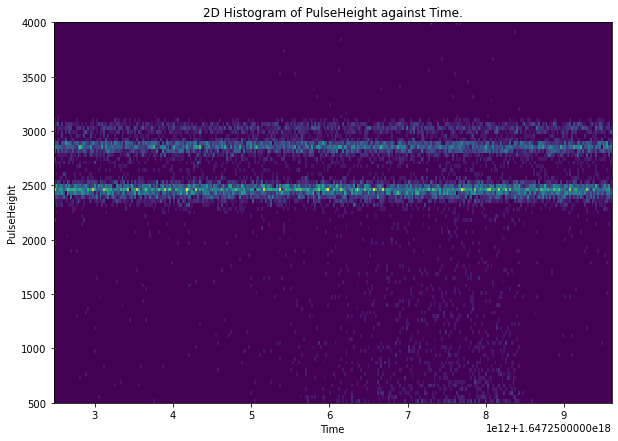

In [108]:
ssd_analysis.run()

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([1.64725247e+18, 1.64725250e+18, 1.64725252e+18, 1.64725254e+18,
        1.64725257e+18, 1.64725259e+18, 1.64725262e+18, 1.64725264e+18,
        1.64725266e+18, 1.64725269e+18, 1.64725271e+18, 1.64725273e+18,
        1.64725276e+18, 1.64725278e+18, 1.64725280e+18, 1.64725283e+18,
        1.64725285e+18, 1.64725287e+18, 1.64725290e+18, 1.64725292e+18,
        1.64725294e+18, 1.64725297e+18, 1.64725299e+18, 1.64725301e+18,
        1.64725304e+18, 1.64725306e+18, 1.64725308e+18, 1.64725311e+18,
        1.64725313e+18, 1.64725316e+18, 1.64725318e+18, 1.64725320e+18,
        1.64725323e+18, 1.64725325e+18, 1.64725327e+18, 1.64725330e+18,
        1.64725332e+18, 1.64725334e+18, 1.64725337e+18, 1.64725339e+18,
        1.64725341e+18, 1.64725

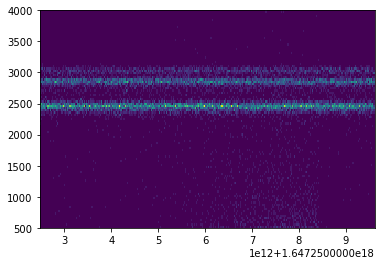